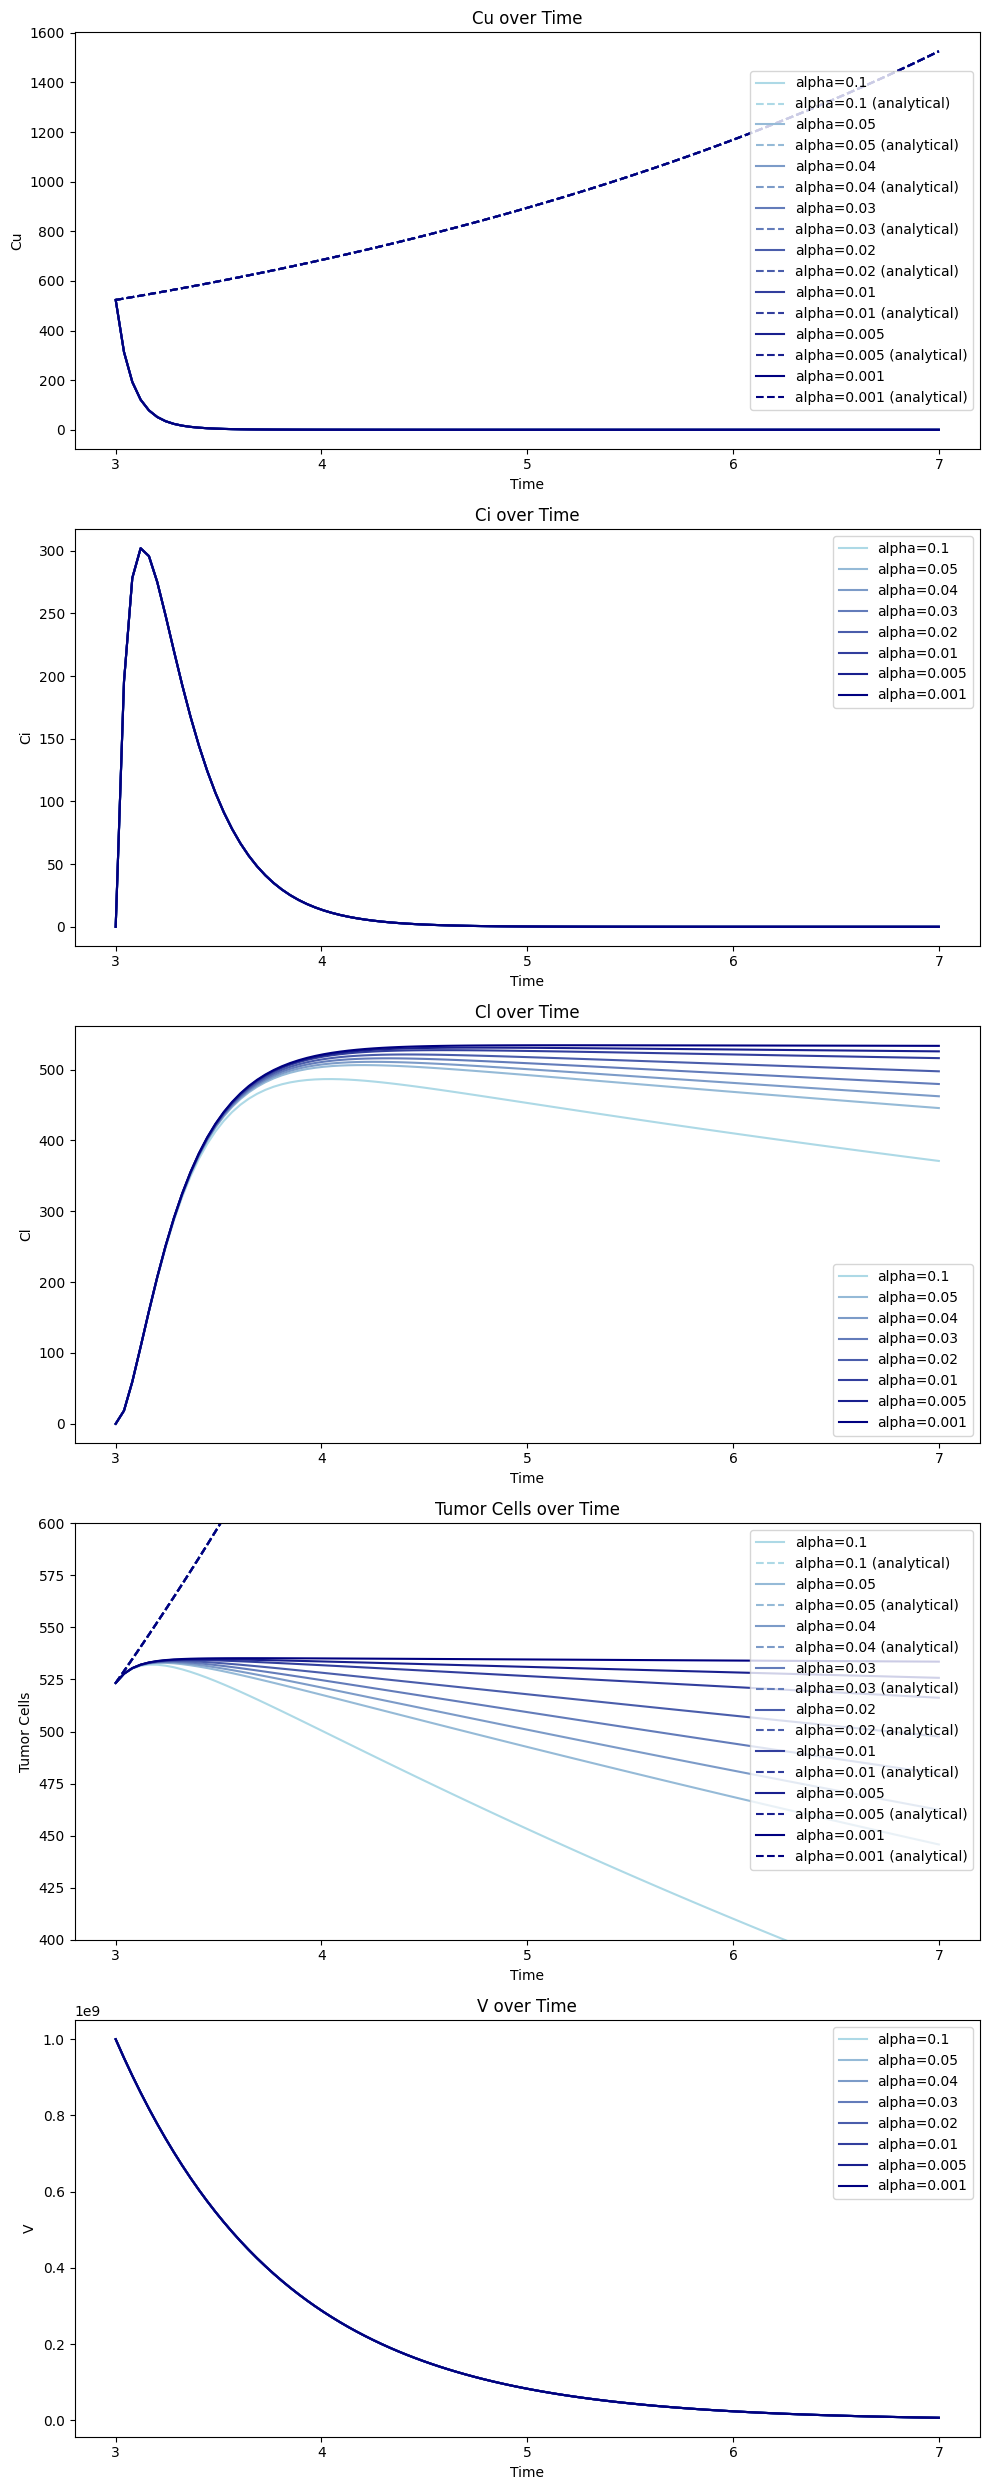

In [62]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm, Normalize, LinearSegmentedColormap

# analytical solution for C_u without the effect of the OV
def C_u(t, kappa, rho, Cu_0 = 400.):
    # return the value of C_u at time t
    return 1/(kappa + np.exp(-rho*t)*(1/Cu_0 - kappa))

# ODE system definition
def ode_system(y, t, rho, kappa, psi, phi, alpha, beta, delta_v):
    Cu, Ci, Cl, V = y

    # Ensure variables are non-negative
    Cu = max(Cu, 0)
    Ci = max(Ci, 0)
    Cl = max(Cl, 0)
    V = max(V, 0)

    dCu_dt = rho * Cu * (1 - kappa * (Cu + Ci + Cl)) - psi * V * Cu
    dCi_dt = psi * V * Cu - phi * Ci
    dCl_dt = phi * Ci - alpha * Cl
    dV_dt = beta * alpha * Cl - psi * V * Cu - delta_v * V
    return [dCu_dt, dCi_dt, dCl_dt, dV_dt]

# Time vector
t_end = 4
t = np.linspace(0, t_end, 100)

# Fixed parameters
rho = 0.27 # 1.266002217613888
phi = 4.155901567637312
# alpha = 0.6539044603883554
delta_v = 1.2438014590669062
psi = 1.3281136130711493e-08
beta = 1.1776318132879098
kappa = 1e-5

# Parameter ranges to sweep over
alpha_values = [0.1, 0.05, 0.04, 0.03, 0.02, 0.01, 0.005, 0.001]

# Function to create a custom single-color gradient
def create_color_gradient(start_color, end_color, n):
    """
    Generates a list of colors forming a gradient between start_color and end_color.

    Parameters:
        start_color (tuple): RGB values of the start color (0 to 1 range).
        end_color (tuple): RGB values of the end color (0 to 1 range).
        n (int): Number of colors to generate.

    Returns:
        list: List of RGB tuples.
    """
    return [
        (
            start_color[0] + (end_color[0] - start_color[0]) * i / (n - 1),
            start_color[1] + (end_color[1] - start_color[1]) * i / (n - 1),
            start_color[2] + (end_color[2] - start_color[2]) * i / (n - 1),
        )
        for i in range(n)
    ]

# Define the start and end colors for the gradient (e.g., light blue to dark blue)
start_color = (0.68, 0.85, 0.90)  # Light Blue (e.g., Powder Blue)
end_color = (0.0, 0.0, 0.5)       # Dark Blue (e.g., Navy)

# Generate the color gradient
colors = create_color_gradient(start_color, end_color, len(alpha_values))

# Prepare the plot
fig, axes = plt.subplots(5, 1, figsize=(10, 25))
axes = axes.flatten()  # To easily iterate over subplots

# Labels for subplots
variables = ['Cu', 'Ci', 'Cl', 'Tumor Cells', 'V']

for idx, alpha in enumerate(alpha_values):

    # Initial conditions
    y0 = [1 / (kappa + np.exp(-rho) * (1./400 - kappa)), 0., 0., 1e9]

    # Solve ODE
    sol = odeint(ode_system, y0, t, args=(rho, kappa, psi, phi, alpha, beta, delta_v))
    Cu, Ci, Cl, V = sol.T  # Transpose to unpack columns

    # Analytical solution for Cu
    Cu_analytical = C_u(t+1, kappa, rho)

    # Plot each variable in its respective subplot
    axes[0].plot(t, Cu, label=f'alpha={alpha}', color=colors[idx])
    axes[0].plot(t, Cu_analytical, label=f'alpha={alpha} (analytical)', color=colors[idx], linestyle='dashed')
    axes[1].plot(t, Ci, label=f'alpha={alpha}', color=colors[idx])
    axes[2].plot(t, Cl, label=f'alpha={alpha}', color=colors[idx])
    axes[3].plot(t, (Cu+Ci+Cl), label=f'alpha={alpha}', color=colors[idx])
    axes[3].plot(t, (Cu_analytical), label=f'alpha={alpha} (analytical)', color=colors[idx], linestyle='dashed')
    axes[3].set_ylim(400, 600)
    axes[4].plot(t, V, label=f'alpha={alpha}', color=colors[idx])

# Customize each subplot
for ax, var in zip(axes, variables):
    ax.set_title(f'{var} over Time')
    ax.set_xlabel('Time')
    ax.set_ylabel(var)
    ax.legend()

    # adjust the x axis to show [3, 4, 5, 6, 7] instead
    ax.set_xticks(np.arange(0, t_end+1))
    ax.set_xticklabels(np.arange(3, t_end+4))
    
plt.tight_layout()
plt.show()